# Machine Learning Model Construction for Single Cell RNA-Seq Clustering Parameter Evaluation Results

## Method

Tabula Muris Droplet, Tabula Muris Spike and Zhengmix datasets were downloaded using R/Bioconductor. Datasets are preprocessed using **scran**. For each dataset, *Shared Nearest Neighbour* based graph construction and graph clustering using 3 popular algorithms, Walktrap, Louvain and Leiden algorithms from **igraph** package.
SNN graphs for each dataset with *number of neighbours* parameter from 1 to 50, Highly Variant Genes as 500, 1000, 1500 and 2000 were constructed. *DenoisePCA* function from scran package is used for PCA. Adjusted Rand Index used for clustering comparison with cell labels. Clusterings with ARI higher than 0.65 are labelled as accepted.

### Applying Machine Learning Algorithms to build a model and show importances of parameters

#### Required Packages

In [1]:
import numpy as np
import pandas as pd
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split
import lightgbm
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error, r2_score, roc_auc_score, roc_curve, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

#### Data Import (Preprocessed using R)

In [2]:
encoded_results = pd.read_csv("encoded_dataset.txt" , sep = "\t")

In [3]:
encoded_results.head()

,Number_of_Neighbours,Number_of_PCs,Number_of_Cells,Number_of_HVGs,AlgorithmLeiden,AlgorithmLouvain,AlgorithmWalktrap,Exp_TypeDroplet,acceptable_ari
0,1,15,2500,500,0,0,1,1,0
1,2,15,2500,500,0,0,1,1,0
2,3,15,2500,500,0,0,1,1,0
3,4,15,2500,500,0,0,1,1,0
4,5,15,2500,500,0,0,1,1,0


In [4]:
labels = encoded_results["acceptable_ari"]

In [5]:
features = encoded_results.drop(["acceptable_ari"] , axis = 1)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(features, labels ,test_size=.25,random_state = 8764)

In [7]:
y_train.sum()

2781

In [8]:
y_test.sum()

919

#### LightGBM Algorithm

In [9]:
lgbm = LGBMClassifier()

In [10]:
lgbm_params = {"learning_rate" : [0.001 , 0.01 , 0.1 , 0.5] , "n_estimators" : [200,500,100,1000] , 
               "max_depth" : [1,2,3,5,8,10] , "num_leaves" : [10,20,25,30,35]}

In [11]:
lgbm_cv_model = GridSearchCV(lgbm, lgbm_params, 
                             cv = 5, n_jobs = -1, verbose = 2).fit(X_train, y_train)

Fitting 5 folds for each of 480 candidates, totalling 2400 fits


In [13]:
lgbm_cv_model.best_params_

{'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200, 'num_leaves': 25}

In [15]:
lgbm_tuned = LGBMClassifier(learning_rate= 0.1, 
                                max_depth= 10, 
                                n_estimators= 200 , num_leaves = 25).fit(X_train, y_train)

In [16]:
y_pred = lgbm_tuned.predict(X_test)

In [17]:
accuracy_score(y_test, y_pred)

0.9737373737373738

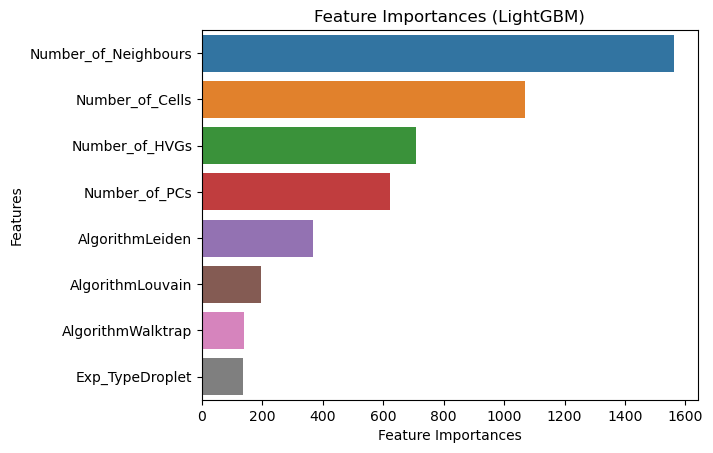

In [18]:
import seaborn as sns

feature_imp = pd.Series(lgbm_tuned.feature_importances_,
                        index=X_train.columns).sort_values(ascending=False)

sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importances')
plt.ylabel('Features')
plt.title("Feature Importances (LightGBM)")
plt.show()

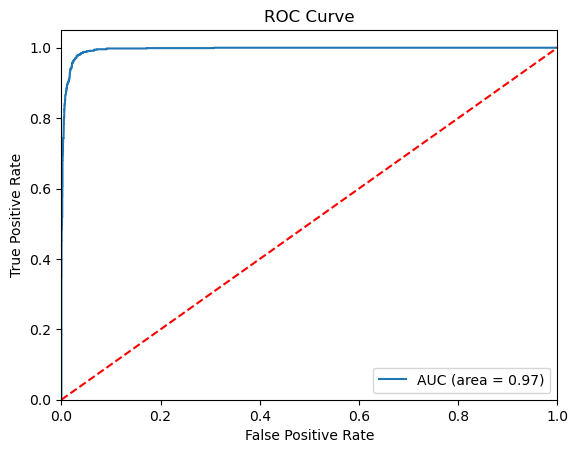

In [19]:
logit_roc_auc = roc_auc_score(y_test, lgbm_tuned.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, lgbm_tuned.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='AUC (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()